In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from collections import defaultdict

import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [2]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
DATA_DIR = 'C:\\Users\\shaki\\OneDrive\\Documents\\GitHub\\FruitQuality\\FruitQuality\\label exports\\Images'
MASK_DIR = 'C:\\Users\\shaki\\OneDrive\\Documents\\GitHub\\FruitQuality\\FruitQuality\\label exports\\Masks'

In [4]:
# BACKBONE = wandb.config.backbone
# BATCH_SIZE = wandb.config.batch_size
CLASSES = list(reversed(['seed', 'pulp', 'albedo', 'flavedo']))
LR = 0.0001
EPOCHS = 200
# EPOCHS = wandb.config.epochs
# ARCHITECTURE_TXT = wandb.config.architecture
ENCODER = 'efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

In [5]:
data_ids = os.listdir(MASK_DIR)
SIZE = len(data_ids)
TRAIN_SIZE = int(0.6 * SIZE)
VAL_SIZE = int(0.2 * SIZE) # Also Test size

In [6]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
class Dataset(BaseDataset):
    """Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['unlabelled', 'seed', 'pulp', 'albedo', 'flavedo']

    def __init__(
            self,
            ids,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = ids
        self.images_fps = [os.path.join(images_dir, image_id)
                           for image_id in self.ids]
        self.masks_fps = [os.path.join(
            masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(
            cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # Resizing
        # image = image_to_same_shape(image, 1024, 1024)
        # mask = image_to_same_shape(mask[..., tf.newaxis], 1024, 1024)[:,:,0]

        # extract certain classes from mask
        masks = [(mask == v*(255//5)+1) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        

        # # add background if mask is not binary
        # if mask.shape[-1] != 1:
        #     background = 1 - mask.sum(axis=-1, keepdims=True)
        #     mask = np.concatenate((mask, background), axis=-1)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


In [8]:
train_dataset = Dataset(
    data_ids[:TRAIN_SIZE],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
)

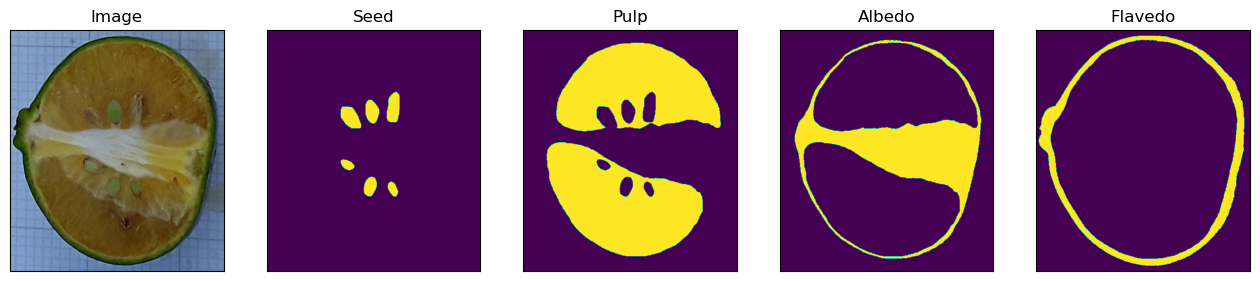

In [9]:
image, mask = train_dataset[4]
visualize(image=image,
          seed=mask[:,:,0],
          pulp=mask[:,:,1],
          albedo=mask[:,:,2],
          flavedo=mask[:,:,3])

In [10]:
def get_training_augmentation():
    train_transform = [

        albu.Resize(1024, 1024)

        # albu.HorizontalFlip(p=0.5),

        # albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=1024, min_width=1024, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=1024, width=1024, always_apply=True),

        # albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        # albu.OneOf(
        #     [
        #         # albu.CLAHE(p=1),
        #         albu.RandomBrightness(p=1),
        #         # albu.RandomGamma(p=1),
        #     ],
        #     p=0.9,
        # ),

        # albu.OneOf(
        #     [
        #         # albu.IAASharpen(p=1),
        #         albu.Blur(blur_limit=3, p=1),
        #         albu.MotionBlur(blur_limit=3, p=1),
        #     ],
        #     p=0.9,
        # ),

        # albu.OneOf(
        #     [
        #         albu.RandomContrast(p=1),
        #         albu.HueSaturationValue(p=1),
        #     ],
        #     p=0.9,
        # ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(1024, 1024, value=0),
        albu.Crop(0,0,1024,1024)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

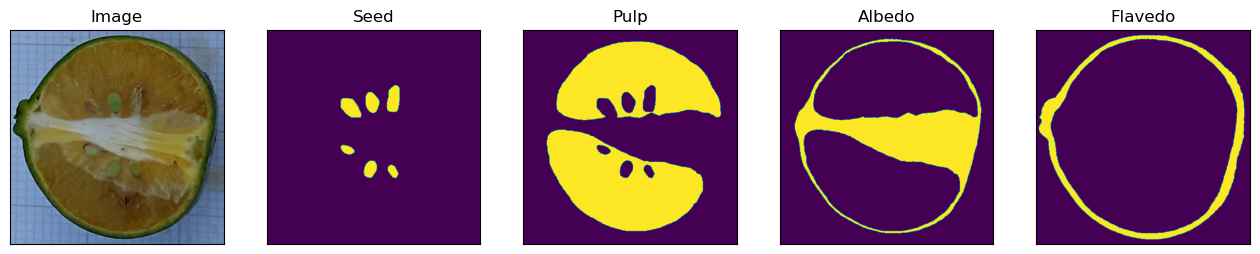

In [11]:
augmented_dataset = Dataset(
    data_ids[:TRAIN_SIZE],
    DATA_DIR,
    MASK_DIR,
    augmentation=get_training_augmentation(), 
    classes=CLASSES,
)

# same image with different random transforms
for i in range(1):
    image, mask = augmented_dataset[4]
    visualize(image=image,
          seed=mask[:,:,0],
          pulp=mask[:,:,1],
          albedo=mask[:,:,2],
          flavedo=mask[:,:,3])

In [12]:
# create segmentation model with pretrained encoder
model = smp.Linknet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [13]:
train_dataset = Dataset(
    data_ids[:TRAIN_SIZE],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    data_ids[TRAIN_SIZE:TRAIN_SIZE+VAL_SIZE],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataset = Dataset(
    data_ids[TRAIN_SIZE+VAL_SIZE:],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset)
test_loader = DataLoader(test_dataset)

dice_loss = sm.losses.DiceLoss()

focal_loss = sm.losses.CategoricalFocalLoss()

total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

In [14]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [16]:
from typing import Optional, Sequence

import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F


class FocalLossExternal(nn.Module):
    """ Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.

    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        """Constructor.

        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v!r}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss


def focal_loss_external(alpha: Optional[Sequence] = None,
               gamma: float = 0.,
               reduction: str = 'mean',
               ignore_index: int = -100,
               device='cpu',
               dtype=torch.float32) -> FocalLossExternal:
    """Factory function for FocalLoss.

    Args:
        alpha (Sequence, optional): Weights for each class. Will be converted
            to a Tensor if not None. Defaults to None.
        gamma (float, optional): A constant, as described in the paper.
            Defaults to 0.
        reduction (str, optional): 'mean', 'sum' or 'none'.
            Defaults to 'mean'.
        ignore_index (int, optional): class label to ignore.
            Defaults to -100.
        device (str, optional): Device to move alpha to. Defaults to 'cpu'.
        dtype (torch.dtype, optional): dtype to cast alpha to.
            Defaults to torch.float32.

    Returns:
        A FocalLoss object
    """
    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)

    fl = FocalLossExternal(
        alpha=alpha,
        gamma=gamma,
        reduction=reduction,
        ignore_index=ignore_index)
    return fl

In [18]:
import torch.nn as nn

from segmentation_models_pytorch.utils import base, functional as F
from segmentation_models_pytorch.base.modules import Activation
from segmentation_models_pytorch.losses._functional import focal_loss_with_logits
from functools import partial

class FocalLoss(base.Loss):
    def __init__(self, alpha = None, gamma = 2.0, ignore_index= None, reduction = "mean", normalized = False, reduced_threshold = None, 
                 class_weights=[1 for _ in range(len(CLASSES)+1)]):
        super().__init__()
        self.ignore_index = ignore_index
        self.class_weights = class_weights
        self.focal_loss_fn = partial(
            focal_loss_with_logits,
            alpha=alpha,
            gamma=gamma,
            reduced_threshold=reduced_threshold,
            reduction=reduction,
            normalized=normalized,
        )

    def forward(self, y_pred, y_true):
        num_classes = y_pred.size(1)
        loss = 0
        # print(y_pred.shape)
        # print(y_true.shape)

        # Filter anchors with -1 label from loss computation
        if self.ignore_index is not None:
            not_ignored = y_true != self.ignore_index

        for cls in range(num_classes):
            cls_y_true = y_true[:, cls, ...]
            cls_y_pred = y_pred[:, cls, ...]

            if self.ignore_index is not None:
                cls_y_true = cls_y_true[not_ignored]
                cls_y_pred = cls_y_pred[not_ignored]

            # loss += self.focal_loss_fn(cls_y_pred, cls_y_true) * self.class_weights[i]
            loss += self.focal_loss_fn(cls_y_pred, cls_y_true)

        return loss
    

In [20]:
class CrossEntropyLoss(base.Loss):
    def __init__(self):
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        return self.cross_entropy_loss(y_pred, y_true)

In [19]:
class CombinedLoss(base.Loss):
    def __init__(self, loss1, loss2, alpha=0.5):
        super().__init__()
        self.loss1 = loss1
        self.loss2 = loss2
        self.alpha = alpha

    def forward(self, y_pred, y_true):
        loss = self.loss1.forward(y_pred, y_true) * self.alpha + self.loss2.forward(y_pred, y_true) * (1 - self.alpha)

        return loss

In [22]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LR),
])

# loss = CustomLoss()
# loss = utils.losses.DiceLoss()
dice_loss = utils.losses.DiceLoss()

# focal_loss = smp.losses.focal.FocalLoss('multiclass')
# focal_loss = smp.losses.FocalLoss(mode='multiclass')
# loss = dice_loss + focal_loss
# alpha = 0.7
# loss =  alpha * FocalLoss() + (1-alpha) * dice_loss
class_weights = [2,1,1,1,1]
loss1 = CombinedLoss(FocalLoss(), dice_loss, 0.7)
loss = CombinedLoss(loss1, nn.CrossEntropyLoss(), 0.8)
# loss = CombinedLoss(FocalLoss(class_weights=class_weights), dice_loss, 0.7)
# loss = CombinedLoss(FocalLossExternal(None, 2), dice_loss, 0.7)


metrics = [
    utils.metrics.IoU(threshold=0.5),
    utils.metrics.Fscore(threshold=0.5)
]

In [23]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

In [24]:
# train model for 40 epochs

max_score = 0
history = defaultdict(list)
last_update = -1
warmup = 5
patience = 5

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    if (i + 1) % 10 == 0:
        print("Test dataset:")
        test_epoch.run(test_loader)

    history['train'].append(train_logs)
    history['valid'].append(valid_logs)

    writer.add_scalar("Loss/train", train_logs['combined_loss'], i)
    writer.add_scalar("Loss/valid", valid_logs['combined_loss'], i)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        last_update = i
        
        
    if i >= warmup and (i - last_update) >= patience:
        optimizer.param_groups[0]['lr'] /= 100 
        last_update = i
        print(f"Decrease decoder learning rate to {optimizer.param_groups[0]['lr']}!")


Epoch: 0
valid: 100%|████████████████| 66/66 [00:10<00:00,  6.33it/s, combined_loss - 0.8543, iou_score - 0.2508, fscore - 0.37]
Model saved!

Epoch: 1
valid: 100%|██████████████| 66/66 [00:11<00:00,  5.89it/s, combined_loss - 0.8064, iou_score - 0.3539, fscore - 0.4868]
Model saved!

Epoch: 2
valid: 100%|██████████████| 66/66 [00:10<00:00,  6.05it/s, combined_loss - 0.7691, iou_score - 0.4626, fscore - 0.5978]
Model saved!

Epoch: 3
valid: 100%|██████████████| 66/66 [00:11<00:00,  5.87it/s, combined_loss - 0.7394, iou_score - 0.5383, fscore - 0.6715]
Model saved!

Epoch: 4
valid: 100%|██████████████| 66/66 [00:11<00:00,  5.97it/s, combined_loss - 0.7222, iou_score - 0.5717, fscore - 0.7003]
Model saved!

Epoch: 5
valid: 100%|██████████████| 66/66 [00:12<00:00,  5.15it/s, combined_loss - 0.7098, iou_score - 0.5946, fscore - 0.7214]
Model saved!

Epoch: 6
valid: 100%|███████████████| 66/66 [00:11<00:00,  5.89it/s, combined_loss - 0.6975, iou_score - 0.6146, fscore - 0.739]
Model saved!

In [25]:
writer.flush()

In [26]:
import pandas as pd

tmp = []
for name in history.keys():
    for i, row in enumerate(history[name]):
        row['name'] = name
        row['epoch'] = i
        tmp.append(row)
df = pd.DataFrame(tmp)
# df.set_index("name", append=True, inplace=True)

In [27]:
df.head()

,combined_loss,iou_score,fscore,name,epoch
0,0.881035,0.208751,0.325474,train,0
1,0.766732,0.502597,0.662721,train,1
2,0.697038,0.635239,0.771153,train,2
3,0.647750,0.747003,0.852673,train,3
4,0.620801,0.784110,0.877206,train,4


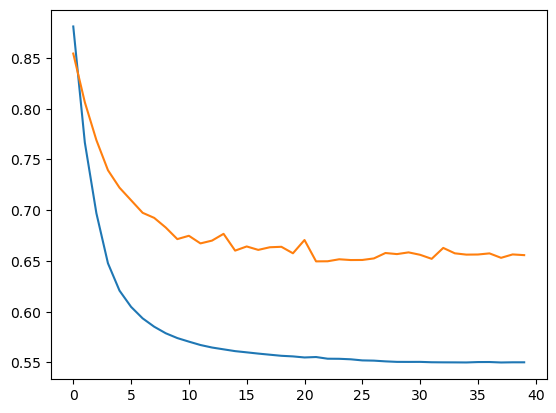

In [28]:
plt.plot(df.loc[df['name']=='train']['epoch'], df.loc[df['name']=='train']['combined_loss'], label='train')
plt.plot(df.loc[df['name']=='valid']['epoch'], df.loc[df['name']=='valid']['combined_loss'], label='valid')
plt.show()

In [29]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [30]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_loader)

valid: 100%|██████████████| 68/68 [00:12<00:00,  5.32it/s, combined_loss - 0.6825, iou_score - 0.5736, fscore - 0.7196]


In [31]:
train_dataset_vis = Dataset(
    data_ids[:TRAIN_SIZE],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
)

In [32]:
test_dataset_vis = Dataset(
    data_ids[TRAIN_SIZE+VAL_SIZE:],
    DATA_DIR,
    MASK_DIR,
    classes=CLASSES,
)

(3, 1024, 1024)
(1024, 1024, 3)
(549, 540, 3)


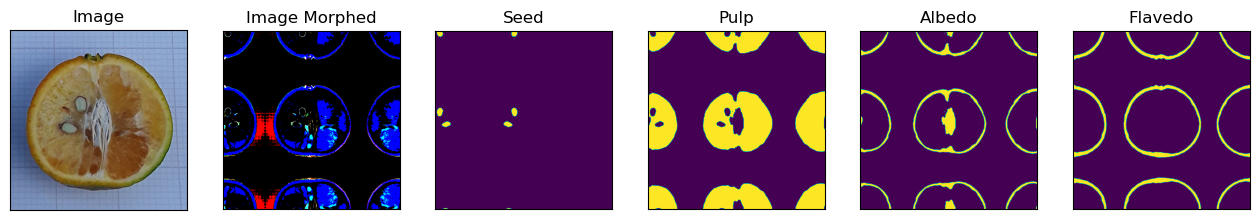

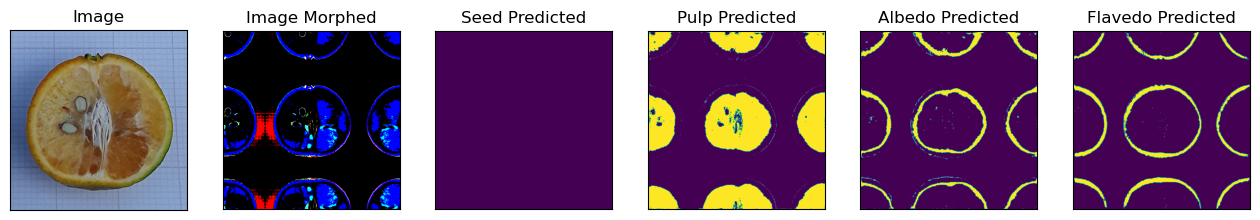

(3, 1024, 1024)
(1024, 1024, 3)
(423, 492, 3)


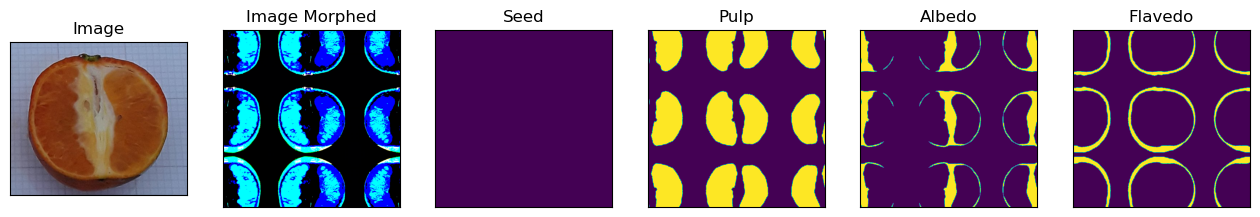

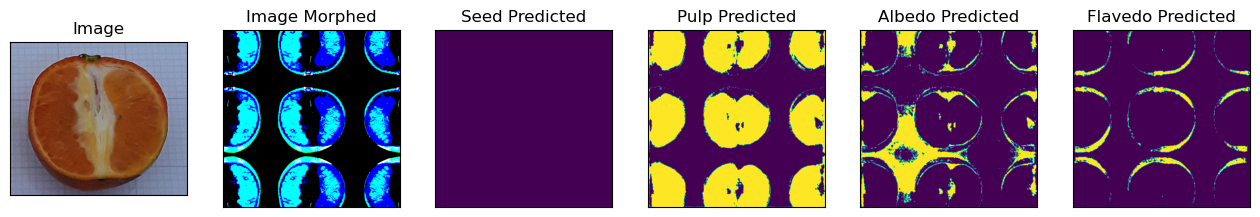

(3, 1024, 1024)
(1024, 1024, 3)
(420, 456, 3)


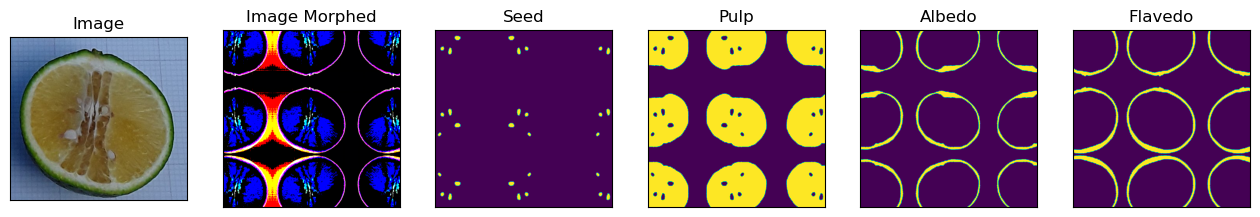

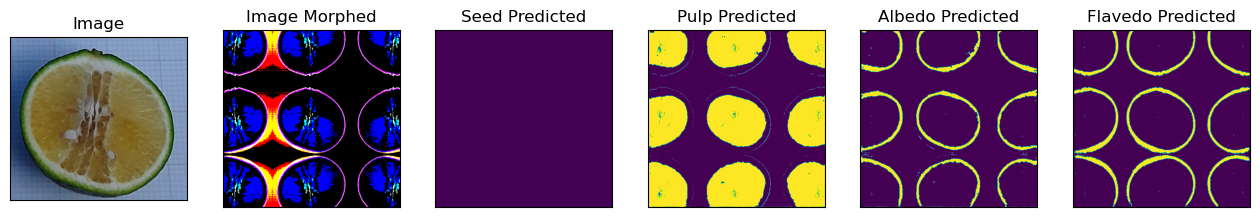

In [33]:
for i in range(3):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
     # x.permute(1, 2, 0).numpy() 
    image_cpy = np.moveaxis(image, [0,1,2], [2,1,0]).astype('uint8')
    image_cpy = image.transpose(1,2,0).astype('uint8')
    print(image.shape)
    print(image_cpy.shape)
    print(image_vis.shape)
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    # visualize(
    #     image=image_vis, 
    #     ground_truth_mask=gt_mask, 
    #     predicted_mask=pr_mask[0]
    # )
    visualize(image=image_vis,
              image_morphed=image_cpy,
          seed=gt_mask[0],
              pulp=gt_mask[1],
          albedo=gt_mask[2],
          flavedo=gt_mask[3])
    visualize(image=image_vis,
              image_morphed=image_cpy,
          seed_predicted=pr_mask[0],
              pulp_predicted=pr_mask[1],
          albedo_predicted=pr_mask[2],
          flavedo_predicted=pr_mask[3])


(3, 1024, 1024)
(1024, 1024, 3)
(499, 463, 3)


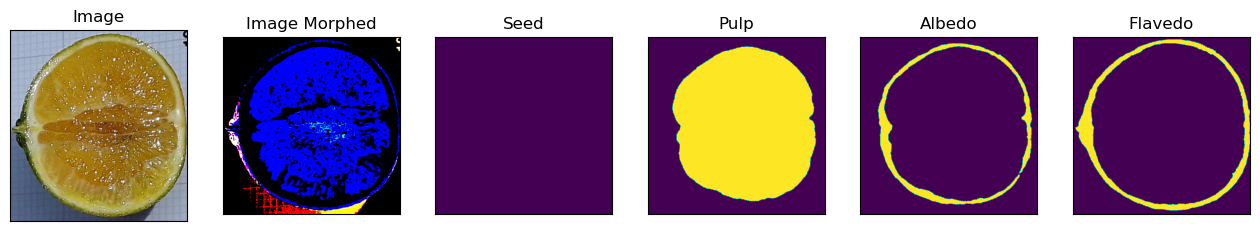

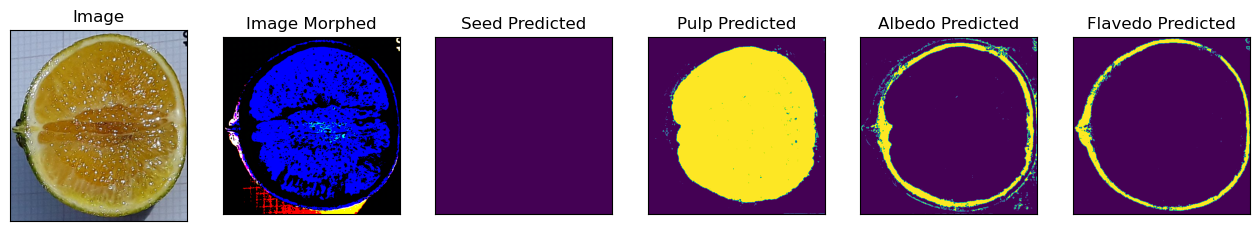

(3, 1024, 1024)
(1024, 1024, 3)
(512, 452, 3)


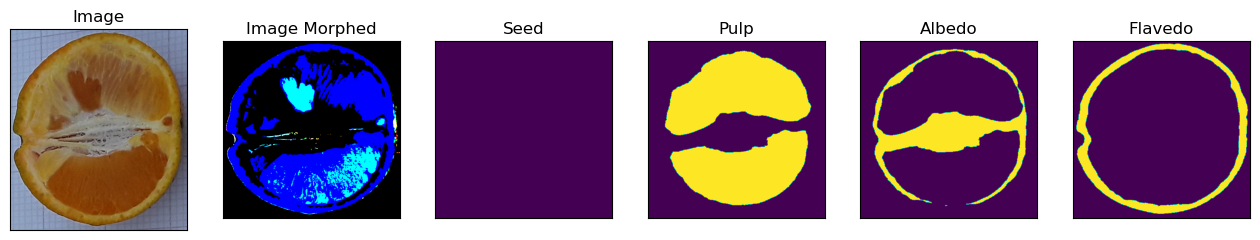

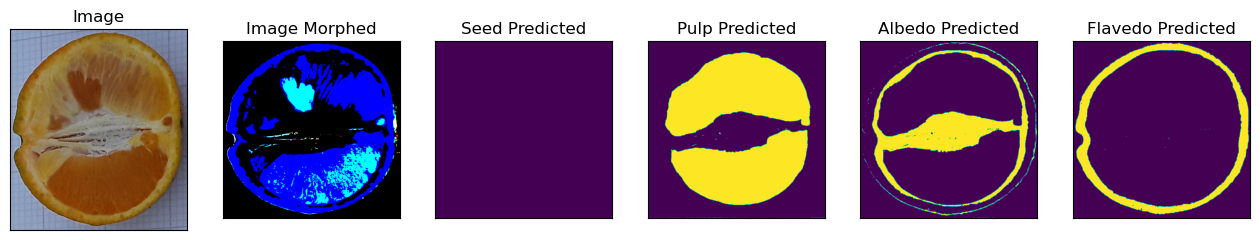

(3, 1024, 1024)
(1024, 1024, 3)
(766, 812, 3)


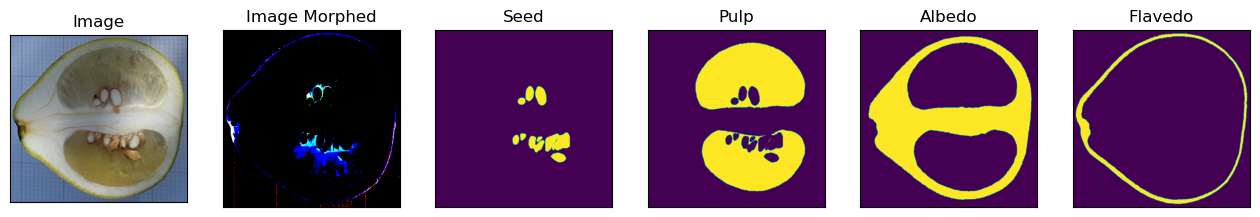

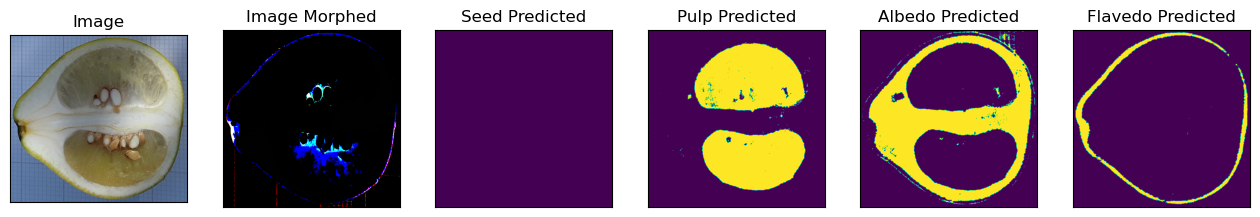

In [34]:
for i in range(3):
    n = np.random.choice(len(train_dataset))
    
    image_vis = train_dataset_vis[n][0].astype('uint8')
    image, gt_mask = train_dataset[n]
     # x.permute(1, 2, 0).numpy() 
    image_cpy = np.moveaxis(image, [0,1,2], [2,1,0]).astype('uint8')
    image_cpy = image.transpose(1,2,0).astype('uint8')
    print(image.shape)
    print(image_cpy.shape)
    print(image_vis.shape)
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    # visualize(
    #     image=image_vis, 
    #     ground_truth_mask=gt_mask, 
    #     predicted_mask=pr_mask[0]
    # )
    visualize(image=image_vis,
              image_morphed=image_cpy,
          seed=gt_mask[0],
              pulp=gt_mask[1],
          albedo=gt_mask[2],
          flavedo=gt_mask[3])
    visualize(image=image_vis,
              image_morphed=image_cpy,
          seed_predicted=pr_mask[0],
              pulp_predicted=pr_mask[1],
          albedo_predicted=pr_mask[2],
          flavedo_predicted=pr_mask[3])
